In [1]:
#pip install --user numpy pandas matplotlib wandb tqdm

In [2]:
#pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import wandb
from tqdm.notebook import tqdm


# Preprocessing

## cuda check

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

## Load CIFAR10 dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

## WandB login

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: floowbaumgartner (floow-fhnw). Use `wandb login --relogin` to force relogin


True

## EDA

In [7]:
#TODO skip (discussed with martin)

# simple diffusion model

## structure

In [8]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="OverfitOneImage")

wandb: Currently logged in as: floowbaumgartner. Use `wandb login --relogin` to force relogin


In [9]:
def get_images_by_label(dataset, target_label, num_samples=1):
    '''
    Retrieves `num_samples` images from `dataset` that have the label `target_label`.
    '''
    images_same_label = []

    # Iterate over the dataset to find images with the desired label
    for img, label in dataset:
        if label == target_label:
            images_same_label.append(img)
        if len(images_same_label) == num_samples:
            break

    # Stack the list of images into a single tensor
    if len(images_same_label) > 0:
        images_overfit = torch.stack(images_same_label)
        return images_overfit
    else:
        return torch.empty(0)

In [10]:
images_overfit = get_images_by_label(trainset, 1, 1)
images_overfit.shape

torch.Size([1, 3, 32, 32])

### forward process (Noise sheduler)

the goal is to sample an image at a timestamp t and deliver it to the model. this makes the training much easier and smoother as the model can learn to denoise the image at each timestep, compared to sequently iterating over the same image over and over again. 

In [11]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Create a linear beta schedule for the diffusion model. it is used to calculate the noise level at each timestep.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension. (helperfunction)
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,device="gpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) #sample noise
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def precompute_terms(betas):
    """
    Precomputes terms required to calculate the noisy version of an image
    """
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance
    }

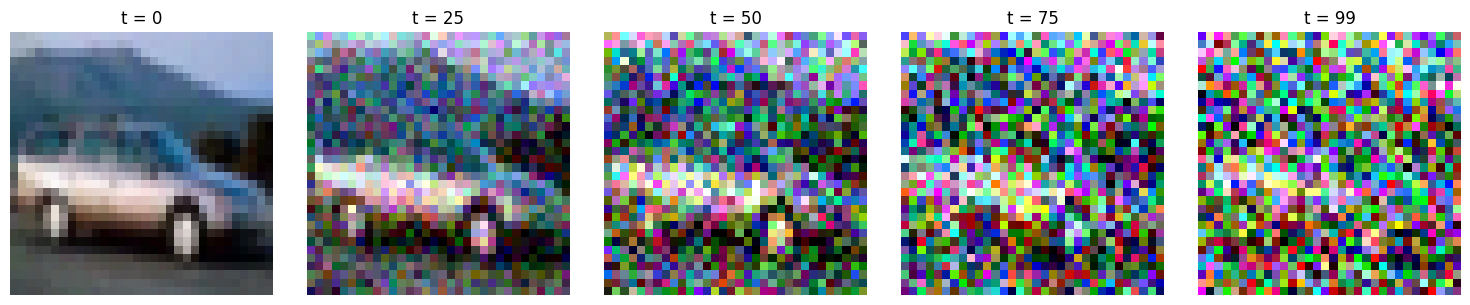

In [12]:
# time steps
T = 100
# create beta schedule
betas = linear_beta_schedule(timesteps=T)
# precompute terms
terms = precompute_terms(betas)
# define timesteps for visualization
timesteps_to_sample = [0, 25, 50, 75, 99]

# ectract single overfit image
x_0 = images_overfit[0].unsqueeze(0) # shape: (1, C, H, W)

# Generate noisy samples at the selected timesteps
noisy_images = []
for t_val in timesteps_to_sample:
    t_tensor = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diffusion_sample(
        x_0, 
        t_tensor, 
        terms["sqrt_alphas_cumprod"], 
        terms["sqrt_one_minus_alphas_cumprod"], 
        device="cpu"
    )
    noisy_images.append(noisy_img[0]) # Remove batch dimension

# Helper function to denormalize and convert tensor for plotting
def denormalize_and_to_numpy(tensor_image):
    """
    Denormalizes and converts a tensor image to numpy for plotting.(helperfunction)
    """
    # The original transform was Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # therefore apply the inverse transform: image * 0.5 + 0.5
    image = tensor_image.clone().detach()
    image = (image * 0.5) + 0.5
    # Clamp to [0,1] for plotting in rgb
    image = image.clamp(0,1)
    # Convert from Channels,Hight,Width (C,H,W) to H,W,C and to numpy
    image_np = image.permute(1,2,0).cpu()#.numpy()
    return image_np


# Plot the original and noisy samples
fig, axes = plt.subplots(1, len(timesteps_to_sample), figsize=(15, 3))
for ax, img, t in zip(axes, noisy_images, timesteps_to_sample):
    ax.imshow(denormalize_and_to_numpy(img))
    ax.set_title(f"t = {t}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Simple Diffusion

In [13]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        #self.bnorm1 = nn.BatchNorm2d(out_ch) #changed to groupnorm
        #self.bnorm2 = nn.BatchNorm2d(out_ch) #changed to groupnorm
        self.gnorm1 = nn.GroupNorm(32, out_ch)
        self.gnorm2 = nn.GroupNorm(32, out_ch)

        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        #h = self.bnorm1(self.relu(self.conv1(x)))# changed to gnorm
        h = self.gnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        # h = self.bnorm2(self.relu(self.conv2(h))) #changed to gnorm
        h = self.gnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

In [14]:
class SimpleUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 128 #changed from 32 and 64
        
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.SiLU() #changed from Relu to SiLU -> SiLU is a smooth version of ReLU and is good for diffusion models because can avoid dead neurons and smoother than ReLU. (but calculation takes longer)
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)


    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [65]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62730819


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=128, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=128, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


### Loss function

In [15]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device,label=None):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t, label)
    return F.mse_loss(noise, noise_pred)

 tried l1_loss and now mse_loss

### sampling

In [75]:
@torch.no_grad() # to prevent memory out of bounds
def sample_timestep(x, t,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance,y=None):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, y) / sqrt_one_minus_alphas_cumprod_t + 1e-5
    ) # 1e-5 is added to prevent division by zero
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.item() == 0:
        # The t's are offset from the t's in the paper https://arxiv.org/pdf/2006.11239
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(T, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas,
                     betas, model, posterior_variance, num_classes=None, labels_default:list=None, visualize=True):
    # Sample random noise
    img = torch.randn((1, 3, 32, 32), device=device)

    num_images = 10
    stepsize = int(T/num_images)
    generated_images = []

    if num_classes is None:
        if visualize:
            plt.figure(figsize=(15,15))
            plt.axis('off')

        for i in range(0, T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep(
                img, t,
                sqrt_one_minus_alphas_cumprod,
                sqrt_recip_alphas,
                betas, model,
                posterior_variance,
                y=None
            )
            
            if i % stepsize == 0:
                if visualize:
                    plt.subplot(1, num_images, int(i/stepsize)+1)
                    plt.imshow(denormalize_and_to_numpy(img[0]))
                    plt.axis('off')
                    
        if visualize:
            plt.imshow(denormalize_and_to_numpy(img[0]))
            plt.axis('off')
            plt.show()
        
        generated_unconditional = [img.clone(),None]
        generated_images.append(generated_unconditional)

    else:
        for label in range(num_classes):
            # Skip labels that are not in the default list
            if labels_default is not None and label not in labels_default:
                continue
                
            # for each label, generate new image
            img = torch.randn((1, 3, 32, 32), device=device)

            if visualize:
                plt.figure(figsize=(15,15))
                plt.axis('off')

            y = torch.tensor([label], dtype=torch.long, device=device)
                
            for i in range(0, T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
                t = torch.full((1,), i, device=device, dtype=torch.long)
                img = sample_timestep(
                    img, t,
                    sqrt_one_minus_alphas_cumprod,
                    sqrt_recip_alphas,
                    betas, model,
                    posterior_variance,
                    y=y
                )
                #img = torch.clamp(img, -1.0, 1.0) TODO: maybe use clamp
                
                if i % stepsize == 0:
                    if visualize:
                        plt.subplot(1, num_images, int(i/stepsize)+1)
                        plt.imshow(denormalize_and_to_numpy(img[0]))
                        plt.axis('off')
            
            if visualize:
                plt.imshow(denormalize_and_to_numpy(img[0]))
                plt.axis('off')
                plt.show()
            
            generated_conditional = [img.clone(),y]
            generated_images.append(generated_conditional)

    return generated_images

## overfittest

In [68]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #changed from 1e-4
epochs = 30_000
BATCH_SIZE = 1
T = 100 #TODO 1000

In [69]:
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {10, 100, 1000, 5000, 10000, 15000, 20000, 25000, 29500}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model, terms["posterior_variance"],la)
                
                wandb.log({
                "epoch": epoch,
                "loss": loss.item(),
            })
            
wandb.finish()

  0%|          | 0/30000 [00:00<?, ?it/s]

TypeError: SimpleUnet.forward() takes 3 positional arguments but 4 were given

### visualize generated images and compare to original

In [31]:
def compare_images(original, generated):
    """
    Zeigt Original und generiertes Bild nebeneinander in einem Plot an.
    original, generated: Tensors mit Shape (C, H, W)
    """
    orig_np = denormalize_and_to_numpy(original)
    gen_np = denormalize_and_to_numpy(generated)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(orig_np)
    axs[0].set_title("Original")
    axs[0].axis("off")
    
    axs[1].imshow(gen_np)
    axs[1].set_title("Generated")
    axs[1].axis("off")
    
    plt.show()

In [ ]:
compare_images(images_overfit[0], x_gen[0])

In [ ]:
x_gen_dn = denormalize_and_to_numpy(x_gen[0])
x_gen_dn.min()

### conclusion
mit batchnorm wurde das bild mit der zeit mit einem bestimmten farbton versehen (ab epoche 1000) mit groupnorm konnte ich das leider auch nicht verhindern, jedoch die genauigkeit der pixel wurde insgesamt besser (bis epoche 10'000). Was auffällt ist, dass die groupnorm bei den ersten schritten ein viel knalligeres bild erzeugt, als mit der batchnorm. Nach einigen hundert, gleicht es sich dann aus. Die groupnorm performt aber dann wieder bei hohen epochen (30'000) besser, es kommt zu originalen farben besser hin.

#fragen:
TODO:
diagnostische plots -> wandb
wie testen -> qualität eines generativen modells testen

## train on full data from one label

In [17]:
model_simpleU = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model_simpleU.parameters()))
model_simpleU

Num params:  62730819


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=128, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=128, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [43]:
T = 100
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_simpleU.to(device)
optimizer = torch.optim.Adam(model_simpleU.parameters(), lr=0.001)
epochs = 1000
BATCH_SIZE = 128

In [44]:
train_1label =get_images_by_label(trainset, 1, 5_000)
print(f"Number of images in label 1 from trainset: {len(train_1label)}")

#init dataloader
trainloader = torch.utils.data.DataLoader(train_1label, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Number of images in label 1 from trainset: 5000


In [45]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="SimpleDiffusion")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 Loss: 0.22344303131103516
Epoch 10 Loss: 0.14039930701255798


/tmp/ipykernel_403/3253869418.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


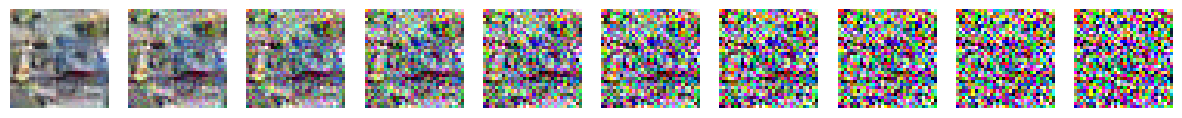

Epoch 20 Loss: 0.10658743232488632
Epoch 30 Loss: 0.12647877633571625
Epoch 40 Loss: 0.12128569185733795
Epoch 50 Loss: 0.13181732594966888


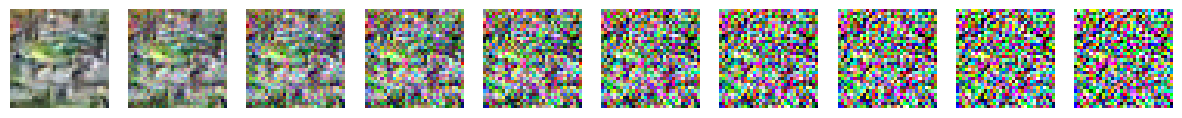

Epoch 60 Loss: 0.10739865154027939
Epoch 70 Loss: 0.11444181203842163


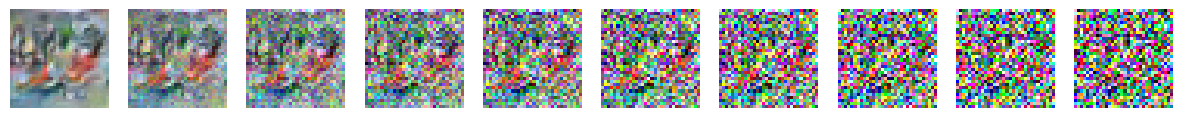

Epoch 80 Loss: 0.09765437245368958
Epoch 90 Loss: 0.12011127918958664


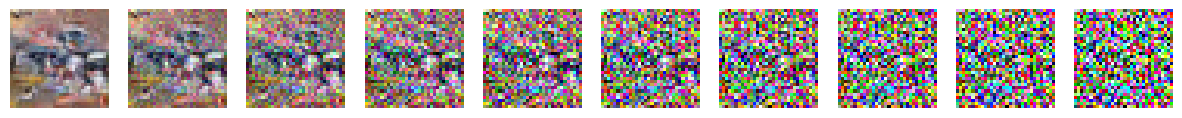

Epoch 100 Loss: 0.1048818826675415


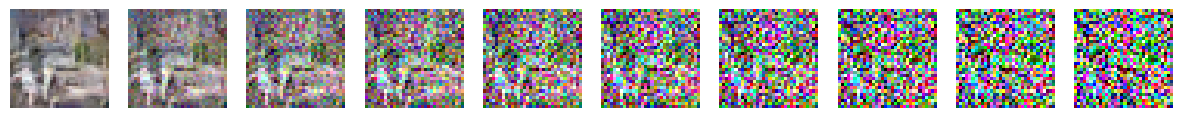

Epoch 110 Loss: 0.1099572628736496
Epoch 120 Loss: 0.11184637993574142
Epoch 130 Loss: 0.09421709179878235
Epoch 140 Loss: 0.09340503066778183
Epoch 150 Loss: 0.09680643677711487
Epoch 160 Loss: 0.09364642947912216
Epoch 170 Loss: 0.09221236407756805
Epoch 180 Loss: 0.09991012513637543
Epoch 190 Loss: 0.08384041488170624
Epoch 200 Loss: 0.10611604154109955


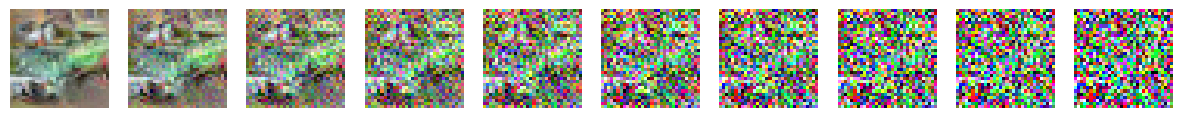

Epoch 210 Loss: 0.09684924781322479
Epoch 220 Loss: 0.08376171439886093
Epoch 230 Loss: 0.08572088181972504
Epoch 240 Loss: 0.09656223654747009
Epoch 250 Loss: 0.09343107044696808
Epoch 260 Loss: 0.07476100325584412
Epoch 270 Loss: 0.07577259838581085
Epoch 280 Loss: 0.08360576629638672
Epoch 290 Loss: 0.09374424070119858


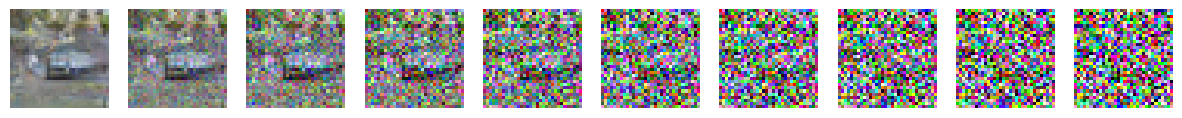

Epoch 300 Loss: 0.06830202043056488


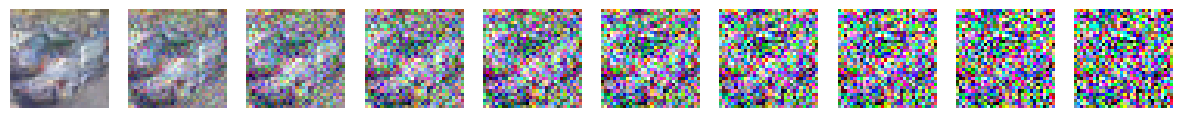

Epoch 310 Loss: 0.0885891541838646
Epoch 320 Loss: 0.08458181470632553
Epoch 330 Loss: 0.078072689473629
Epoch 340 Loss: 0.08204176276922226
Epoch 350 Loss: 0.08962609618902206
Epoch 360 Loss: 0.07758386433124542
Epoch 370 Loss: 0.07488609850406647
Epoch 380 Loss: 0.07768835127353668
Epoch 390 Loss: 0.07841780036687851
Epoch 400 Loss: 0.08089463412761688
Epoch 410 Loss: 0.08046363294124603
Epoch 420 Loss: 0.08828021585941315
Epoch 430 Loss: 0.08687660098075867
Epoch 440 Loss: 0.09010671824216843
Epoch 450 Loss: 0.09231551736593246
Epoch 460 Loss: 0.07768865674734116
Epoch 470 Loss: 0.0782850906252861
Epoch 480 Loss: 0.07604187726974487
Epoch 490 Loss: 0.08596117794513702
Epoch 500 Loss: 0.08267819881439209


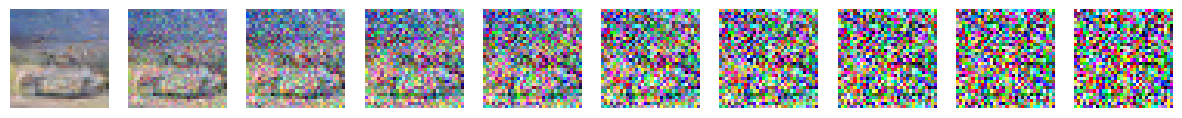

Epoch 510 Loss: 0.08966808766126633
Epoch 520 Loss: 0.06844437122344971
Epoch 530 Loss: 0.07270568609237671
Epoch 540 Loss: 0.0855446606874466
Epoch 550 Loss: 0.09222095459699631
Epoch 560 Loss: 0.07128653675317764
Epoch 570 Loss: 0.07516086846590042
Epoch 580 Loss: 0.09050068259239197
Epoch 590 Loss: 0.062210988253355026
Epoch 600 Loss: 0.0858297199010849
Epoch 610 Loss: 0.0750207006931305
Epoch 620 Loss: 0.07569613307714462
Epoch 630 Loss: 0.0775110274553299
Epoch 640 Loss: 0.07216016203165054
Epoch 650 Loss: 0.08437728881835938
Epoch 660 Loss: 0.07533477991819382
Epoch 670 Loss: 0.06142763793468475
Epoch 680 Loss: 0.08530651032924652
Epoch 690 Loss: 0.08042636513710022
Epoch 700 Loss: 0.0684335008263588
Epoch 710 Loss: 0.06905203312635422
Epoch 720 Loss: 0.06697617471218109
Epoch 730 Loss: 0.08447699248790741
Epoch 740 Loss: 0.08216626942157745
Epoch 750 Loss: 0.06861741840839386
Epoch 760 Loss: 0.06758196651935577
Epoch 770 Loss: 0.07715955376625061
Epoch 780 Loss: 0.06726494431495

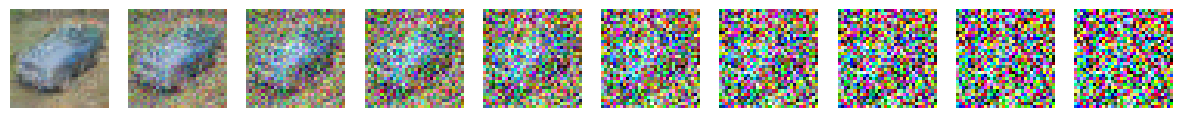

Epoch 810 Loss: 0.06385883688926697
Epoch 820 Loss: 0.07581350207328796
Epoch 830 Loss: 0.06698217242956161
Epoch 840 Loss: 0.07924801111221313
Epoch 850 Loss: 0.07231894135475159
Epoch 860 Loss: 0.05963075906038284
Epoch 870 Loss: 0.058986689895391464
Epoch 880 Loss: 0.06899872422218323
Epoch 890 Loss: 0.053944677114486694
Epoch 900 Loss: 0.06659255921840668


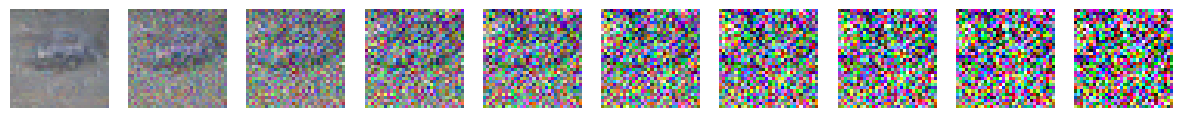

Epoch 910 Loss: 0.06853342801332474
Epoch 920 Loss: 0.06854940950870514
Epoch 930 Loss: 0.06292080879211426
Epoch 940 Loss: 0.06186249852180481
Epoch 950 Loss: 0.07728197425603867
Epoch 960 Loss: 0.06041453033685684
Epoch 970 Loss: 0.058869268745183945
Epoch 980 Loss: 0.06557957828044891
Epoch 990 Loss: 0.05266978591680527


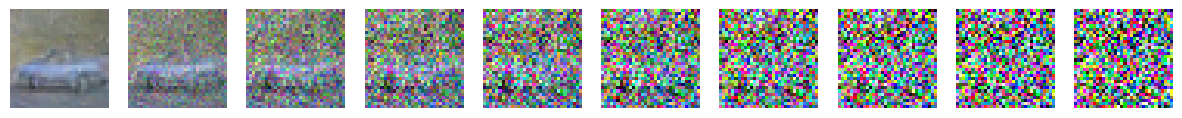

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▆▅▇▆▅▅▆▄▄▅▄▅▄▅▄▄▂▃▄▂▃▃▃▄▂▄▂▄▂▃▂▃▂▃▃▁▂▂▁
epoch,990
loss,0.05267


In [46]:
for epoch in tqdm(range(epochs)):
    model_simpleU.train()
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_simpleU, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {10, 50, 70, 90, 100, 200, 290, 300, 500, 800, 900, 990, 1000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"])
                
        wandb.log({
        "epoch": epoch,
        "loss": loss.item(),
    })
                
wandb.finish()

### visualize generated images and compare to original

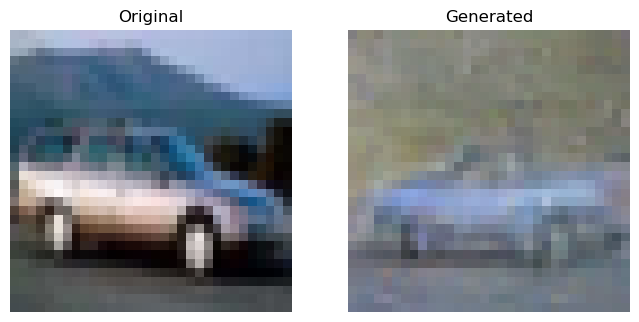

In [47]:
# show last created image
compare_images(train_1label[0], x_gen[0])

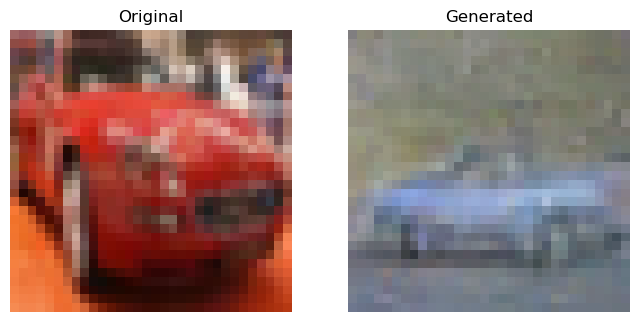

In [48]:
compare_images(train_1label[1], x_gen[0])

/tmp/ipykernel_403/3253869418.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


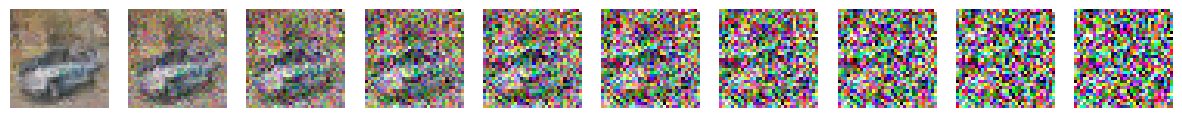

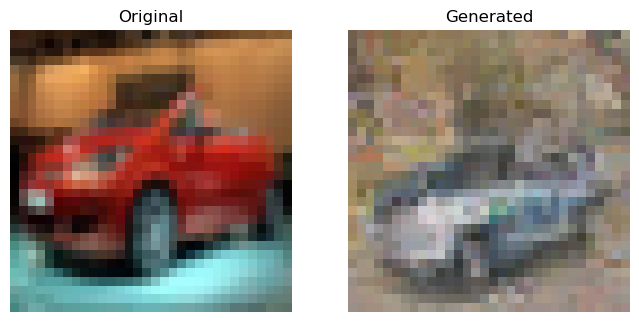

In [59]:
with torch.no_grad():
    x_gen_new = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"],None)

compare_images(train_1label[4], x_gen_new[0])

/tmp/ipykernel_403/3253869418.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


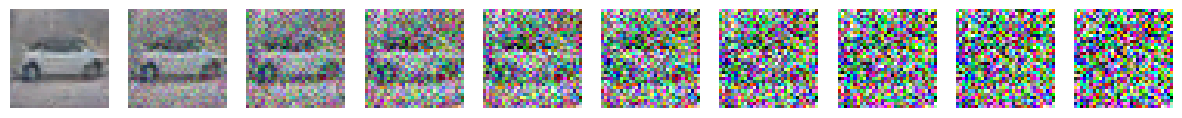

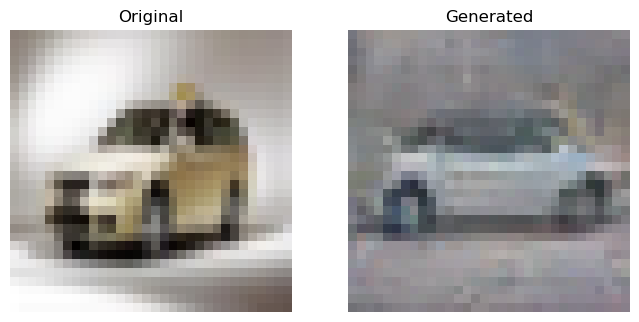

In [62]:
#test and let the model generate an image
with torch.no_grad():
    x_gen_new = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"],visualize=False)

compare_images(train_1label[100], x_gen_new[0])

/tmp/ipykernel_403/3253869418.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


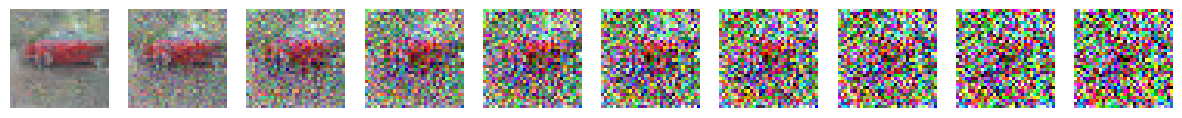

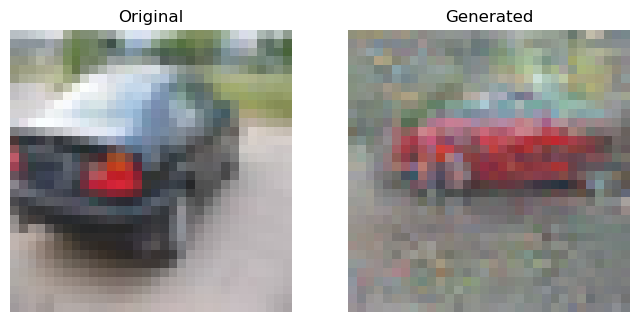

In [69]:
with torch.no_grad():
    x_gen_new = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_simpleU, terms["posterior_variance"],visualize=False)

compare_images(train_1label[1000], x_gen_new[0][0])

### FID Score

In [ ]:
# TODO: FID Score

### conclusion

In [ ]:
# TODO: Conclusion

### save model

In [63]:
# Save params
checkpoint = {
    "epoch": 1000,
    "model_state_dict": model_simpleU.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss
}

torch.save(checkpoint, "checkpoint_simpleU.pt")

In [64]:
#save model
torch.save(model_simpleU, "SimpleU_entire_model.pth")

## train on full data from all labels

In [ ]:
# TODO: train on all labels

### visualize generated images and compare to original

In [ ]:
# TODO: visualize generated images and compare to original

### FID Score

In [ ]:
# TODO: FID Score

### conclusion

In [ ]:
# TODO: Conclusion

# conditonal diffusion model

In [18]:
class ConditionalUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self, num_classes=None):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 128 #changed from 32 and 64
        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.SiLU() #changed from Relu to SiLU -> SiLU is a smooth version of ReLU and is good for diffusion models because can avoid dead neurons and smoother than ReLU. (but calculation takes longer)
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)
        
        # Conditional classes
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_emb_dim)


    def forward(self, x, timestep, y):
        # Embedd time
        t = self.time_mlp(timestep)
        
        #conditional
        if y is not None:
            t += self.label_emb(y)
        
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

## overfittest

In [24]:
num_classes = 2
model_cond = ConditionalUnet(num_classes=num_classes)
print("Num params: ", sum(p.numel() for p in model_cond.parameters()))
model_cond

Num params:  62731075


ConditionalUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=128, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=128, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1,

In [25]:
T = 100 #TODO 1000?
betas = linear_beta_schedule(timesteps=T)
terms = precompute_terms(betas)
model_cond.to(device)
optimizer = torch.optim.Adam(model_cond.parameters(), lr=0.001)
epochs = 1_000
BATCH_SIZE = 2

In [26]:
desired_labels = [0, 1]  # You can change these if you want different classes
desired_indices = []

# We'll go through the dataset and pick the first image for each desired label
found_labels = set()

for idx, (_, label) in enumerate(trainset):
    if label in desired_labels and label not in found_labels:
        desired_indices.append(idx)
        found_labels.add(label)
    # Stop if we've found at least one sample for each desired label
    if len(found_labels) == len(desired_labels):
        break

# 4. Create a Subset containing only those desired indices
trainset = Subset(trainset, desired_indices)

In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
wandb.init(project="DDPM-Conditional", entity="floowbaumgartner", name="overfit-conditional")

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 Loss: 1.0645345449447632
Epoch 100 Loss: 0.23405501246452332


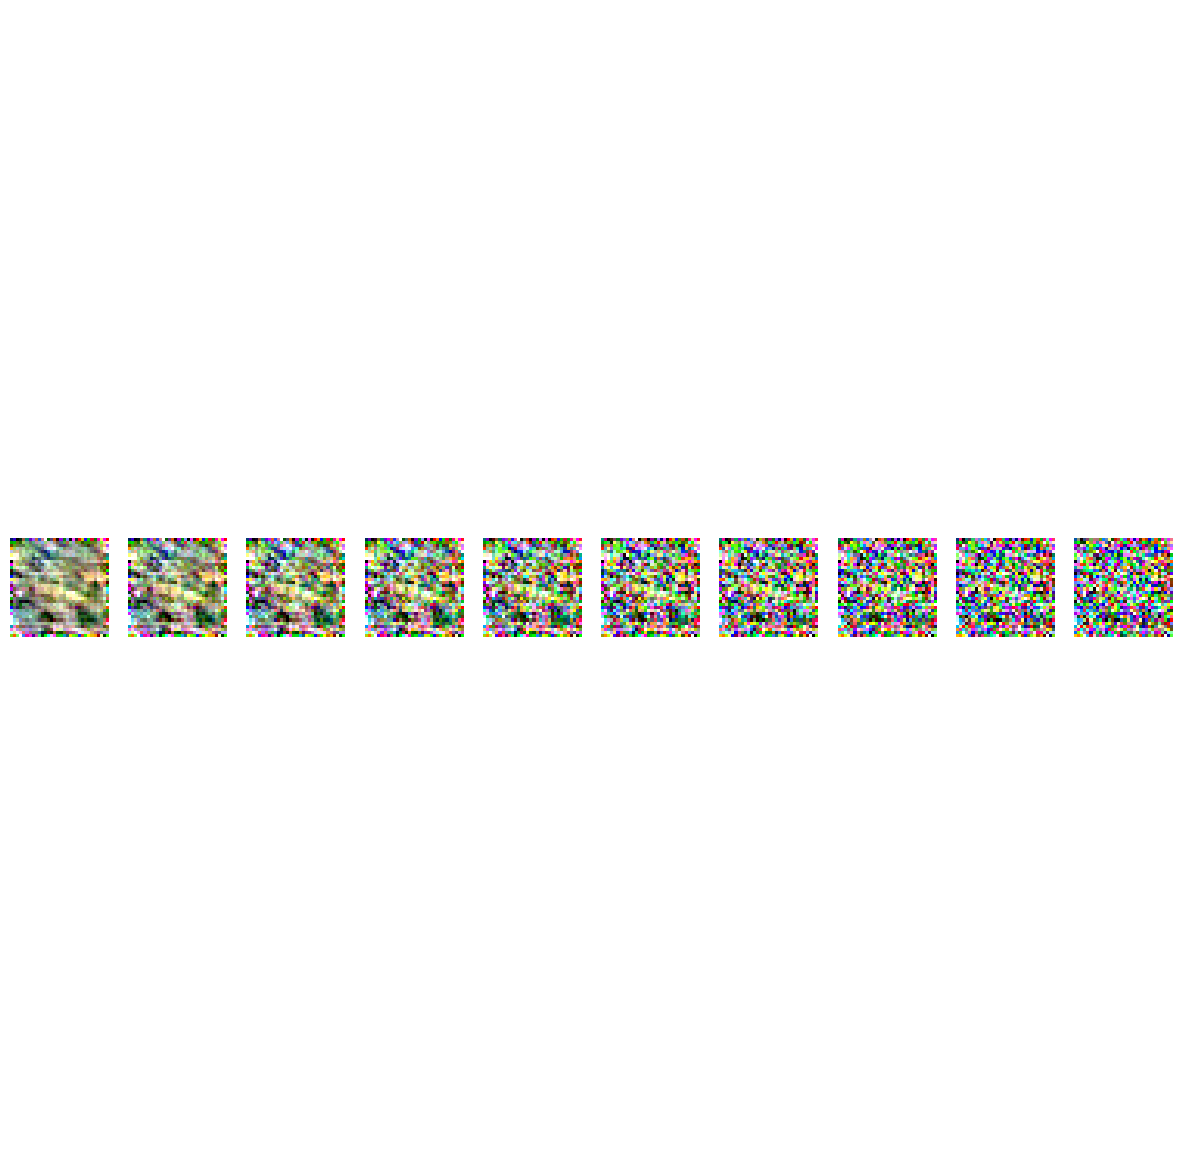

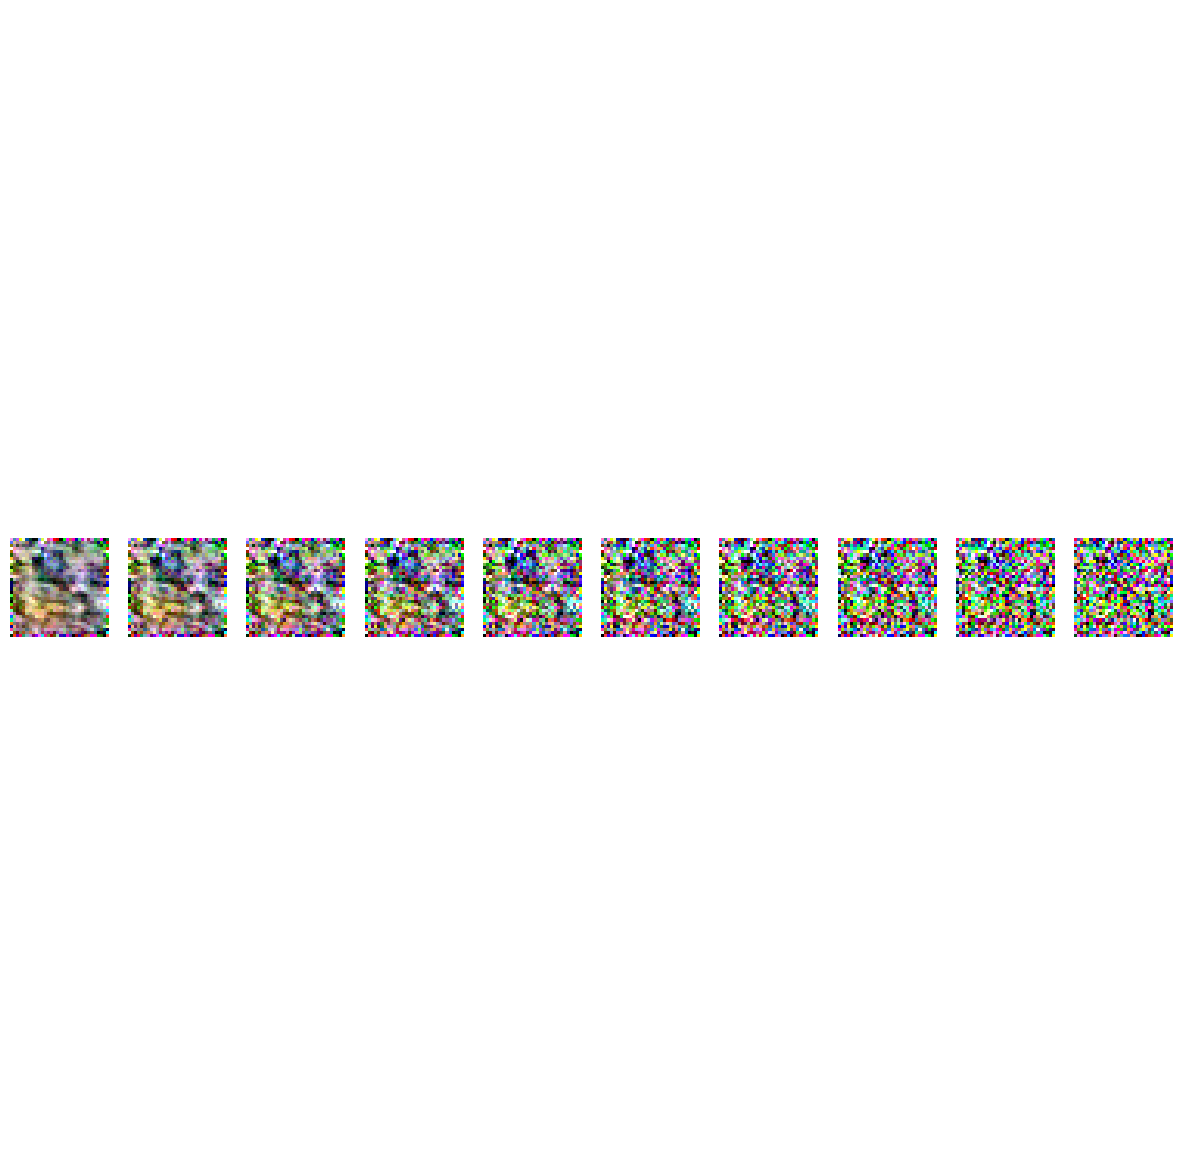

Epoch 200 Loss: 0.19502291083335876


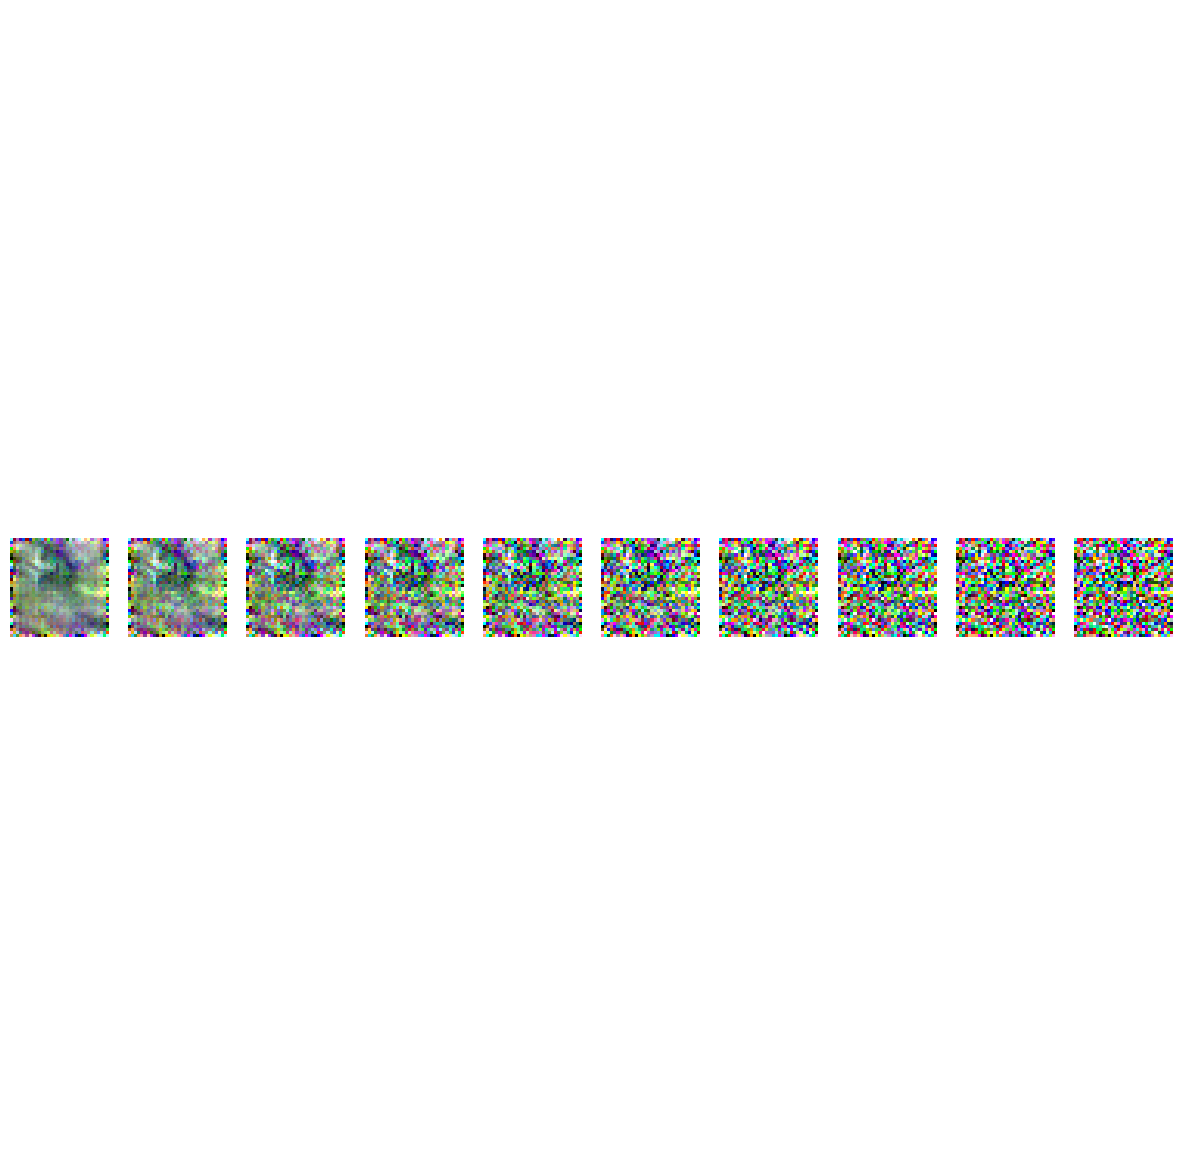

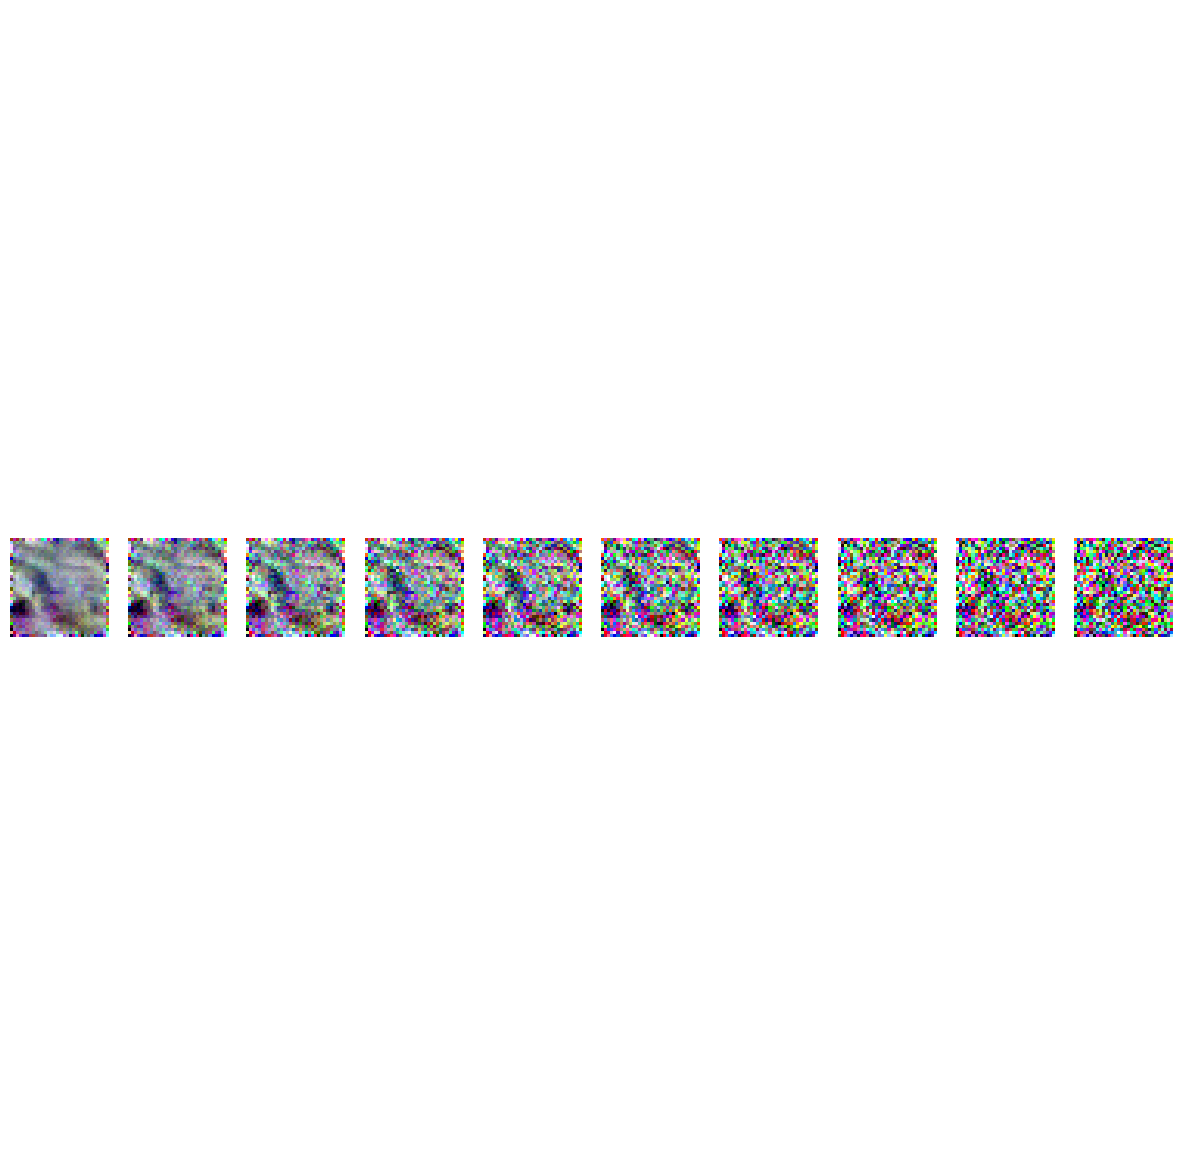

Epoch 300 Loss: 0.06786471605300903


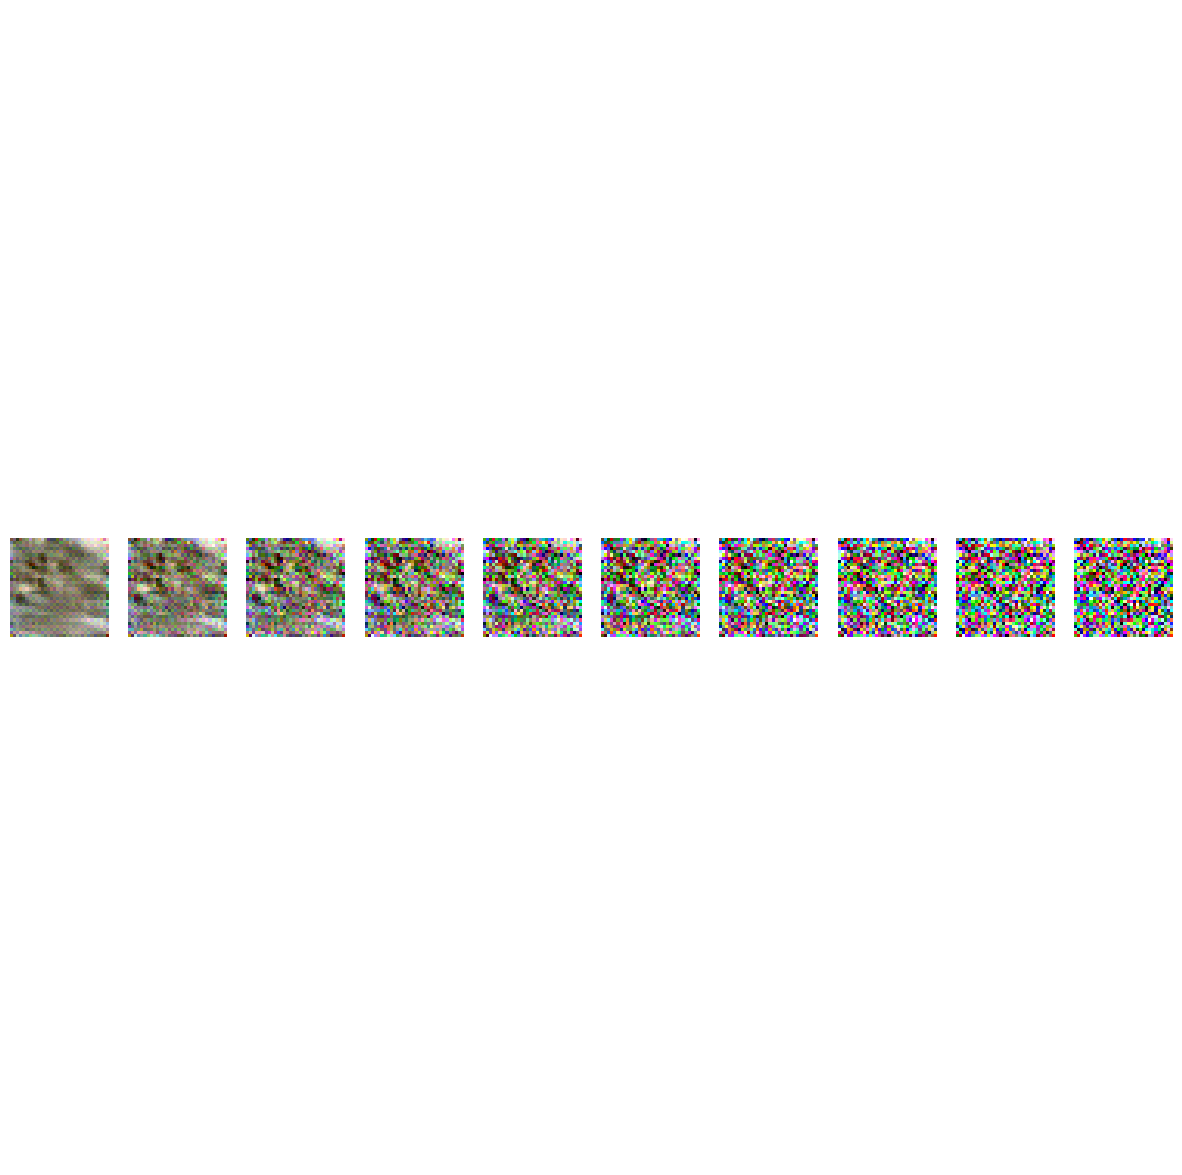

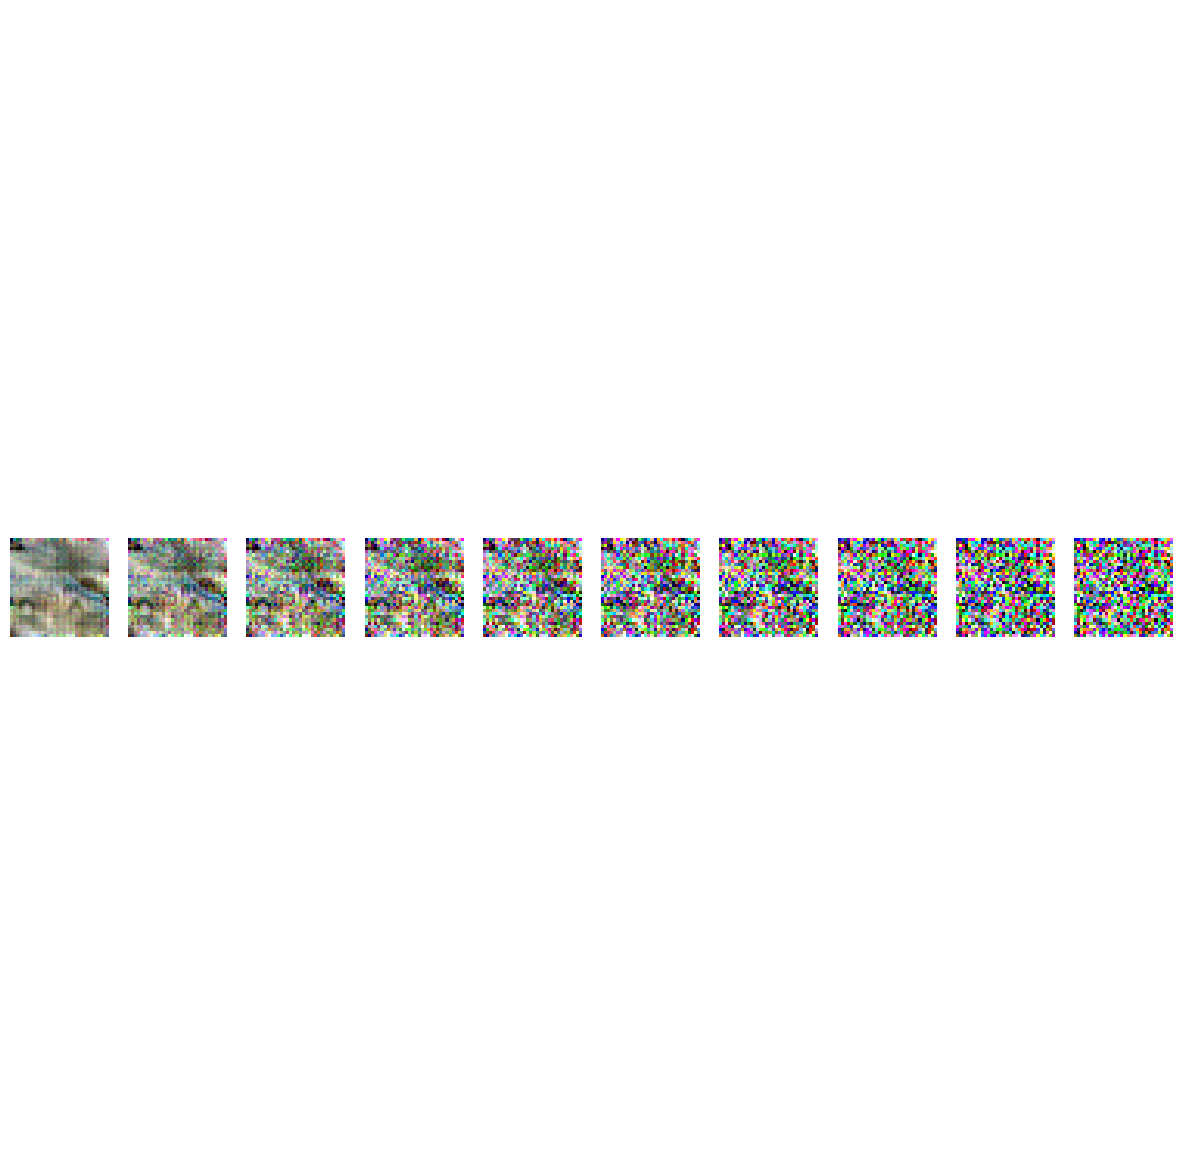

Epoch 400 Loss: 0.04013633728027344
Epoch 500 Loss: 0.12098775804042816


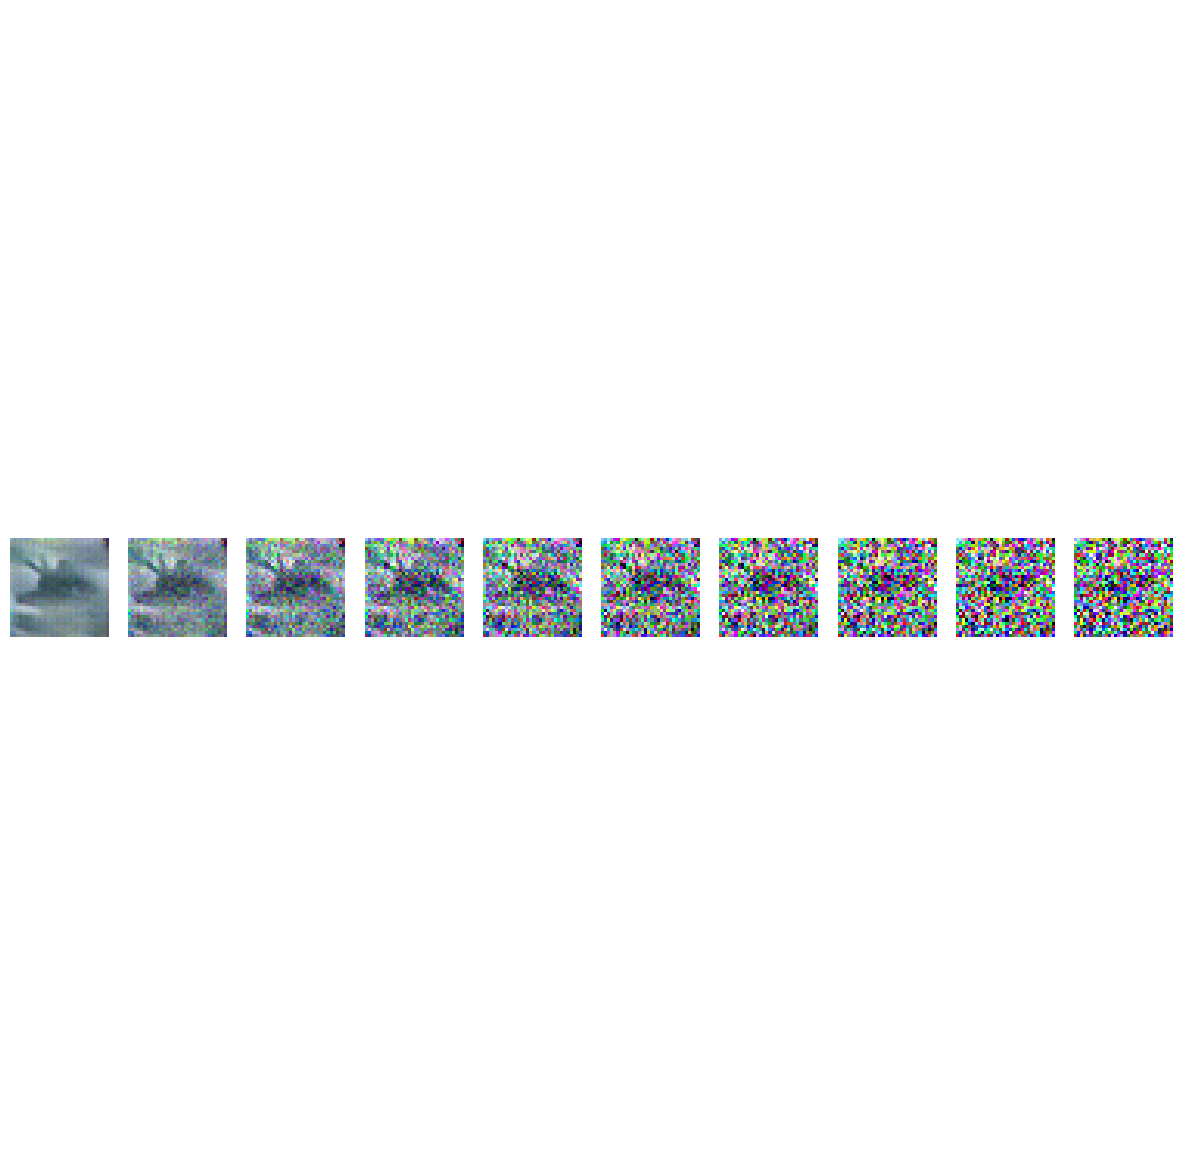

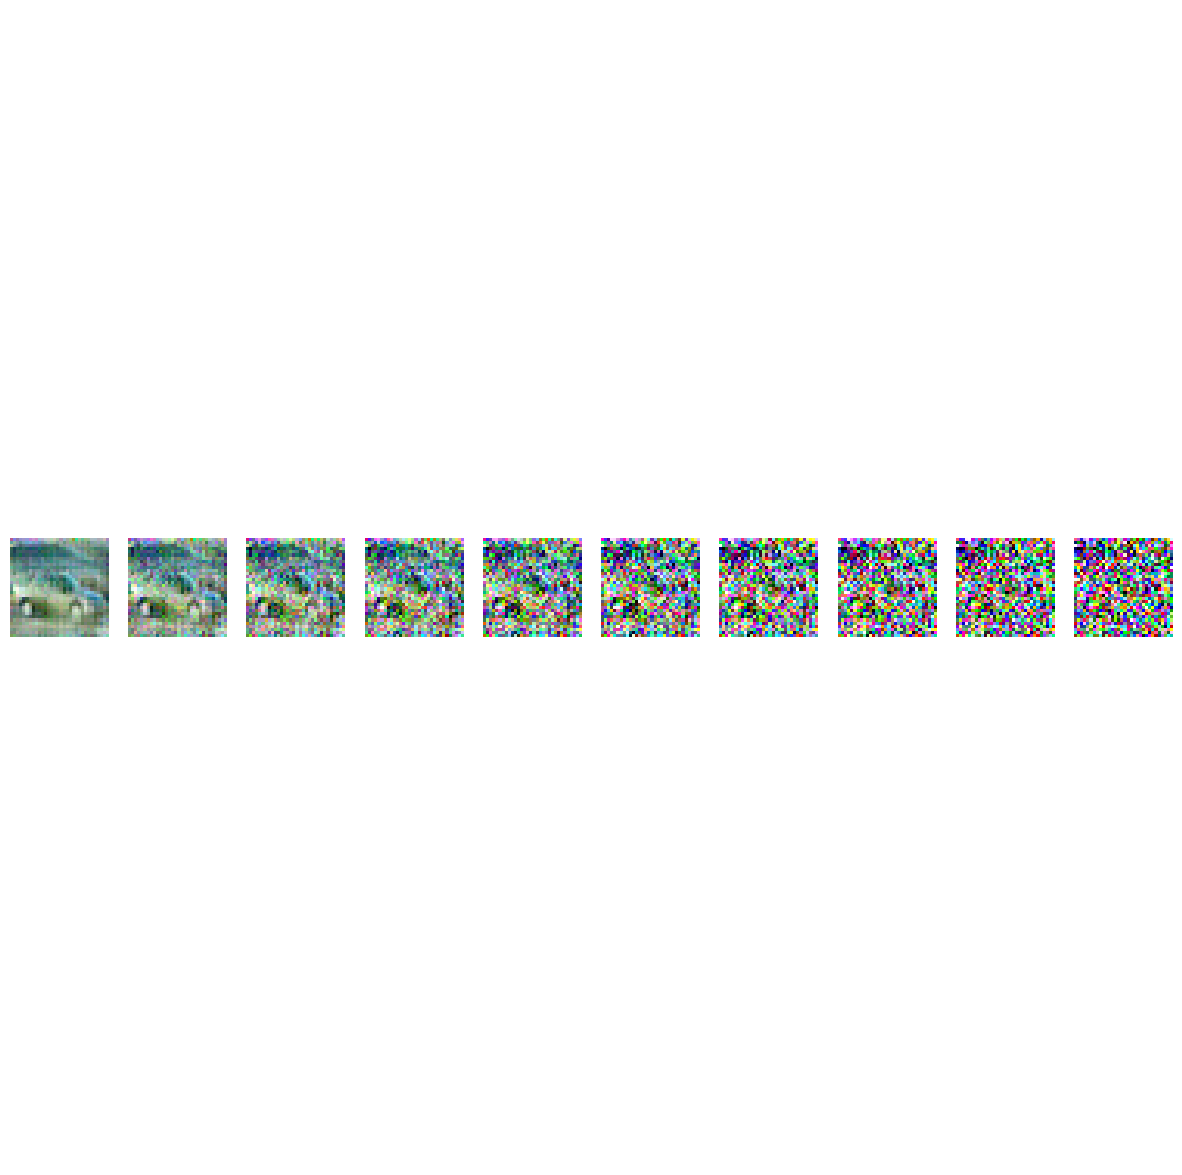

Epoch 600 Loss: 0.03925677761435509
Epoch 700 Loss: 0.2437000721693039
Epoch 800 Loss: 0.06426440924406052


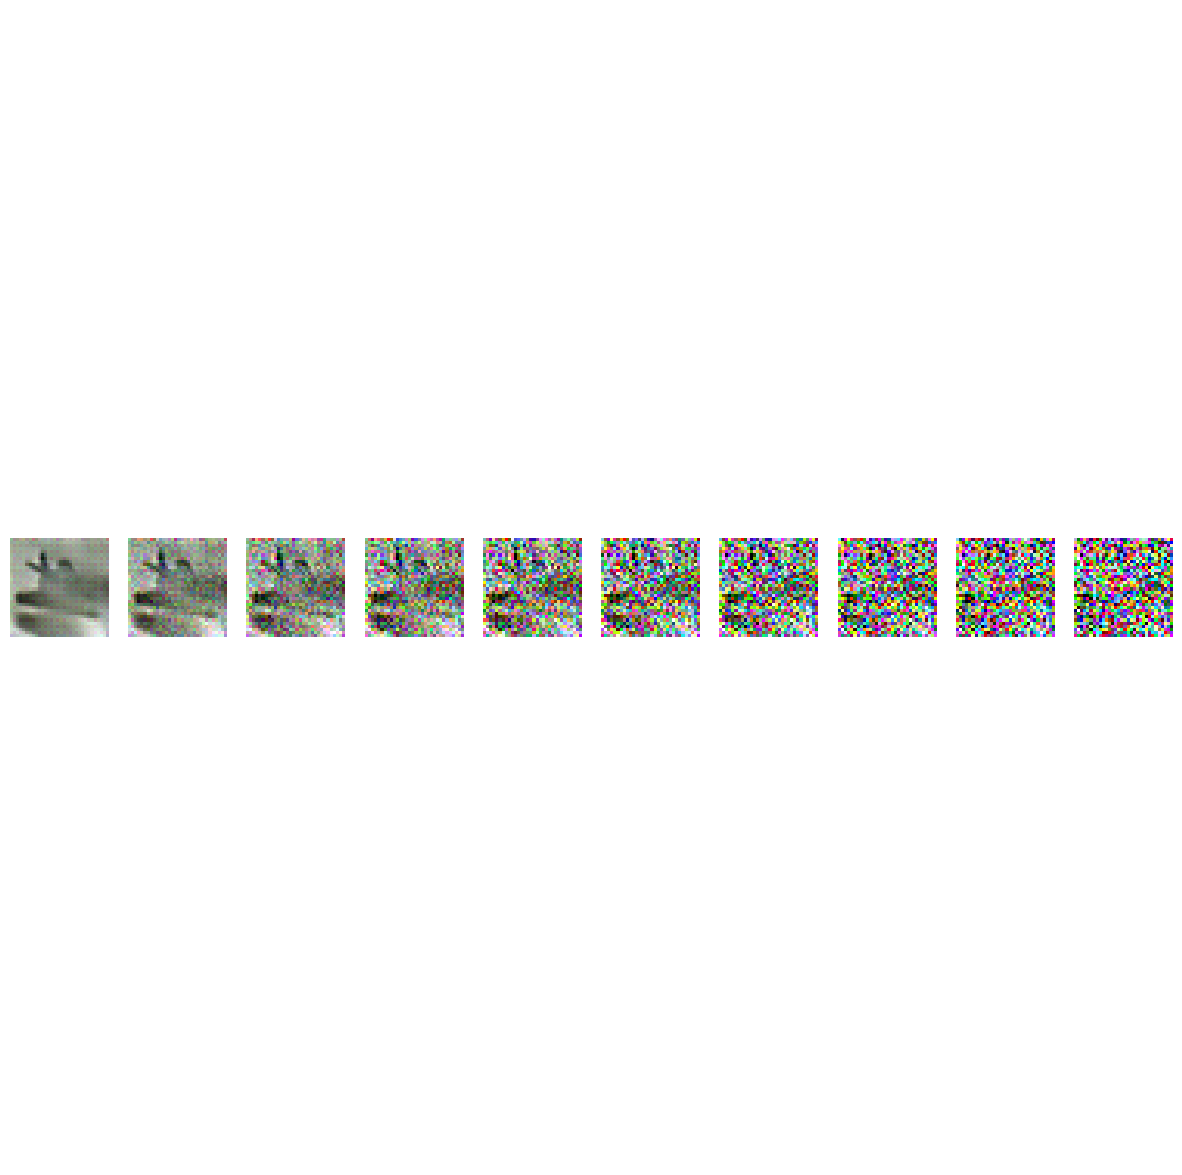

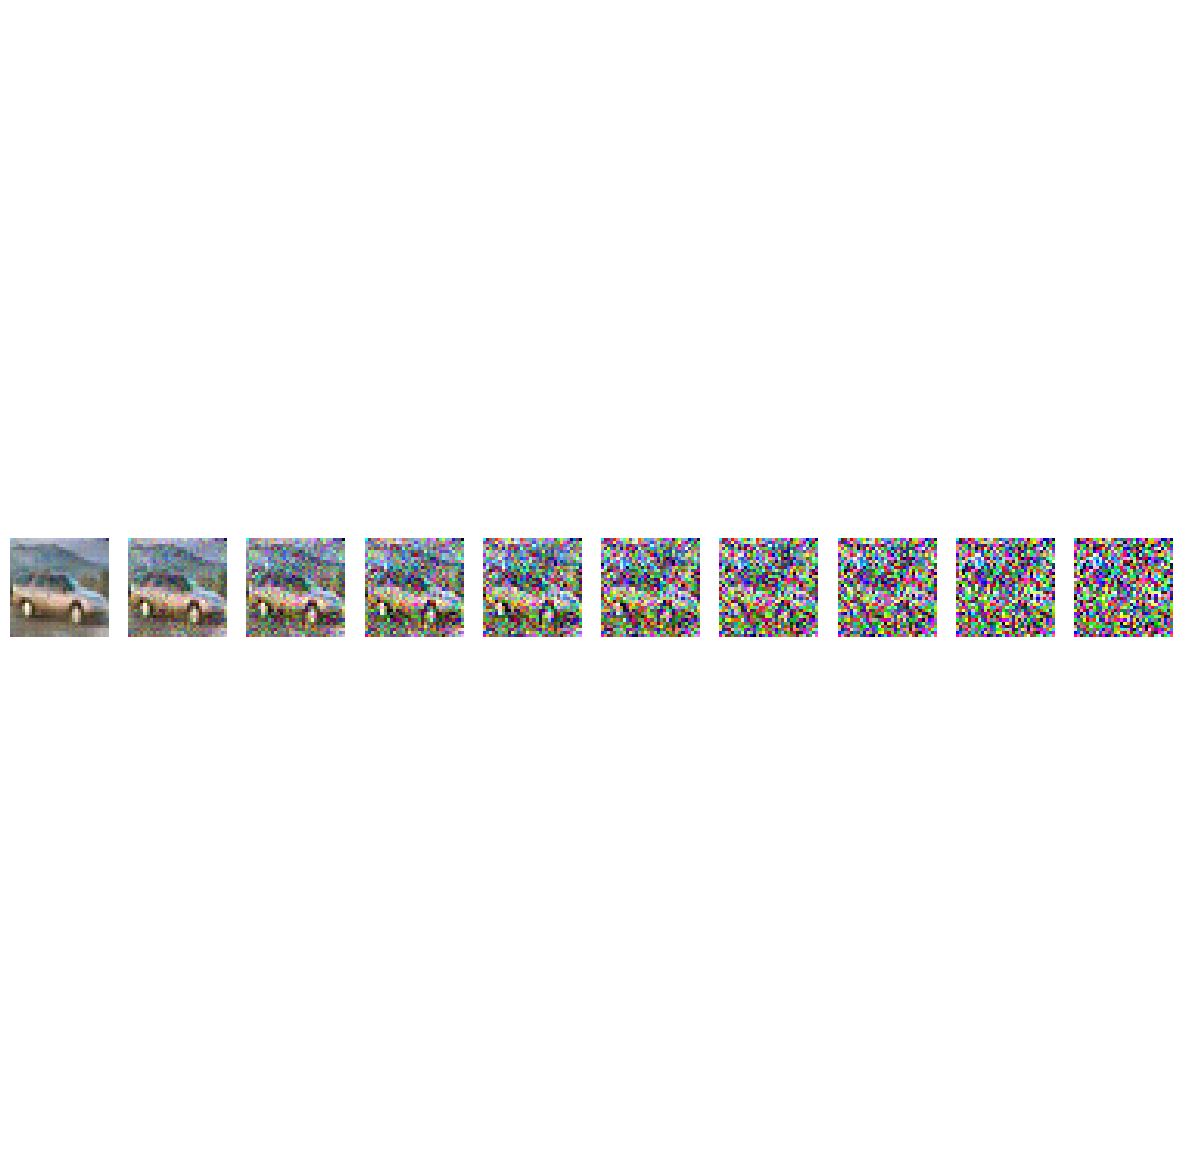

Epoch 900 Loss: 0.056105922907590866


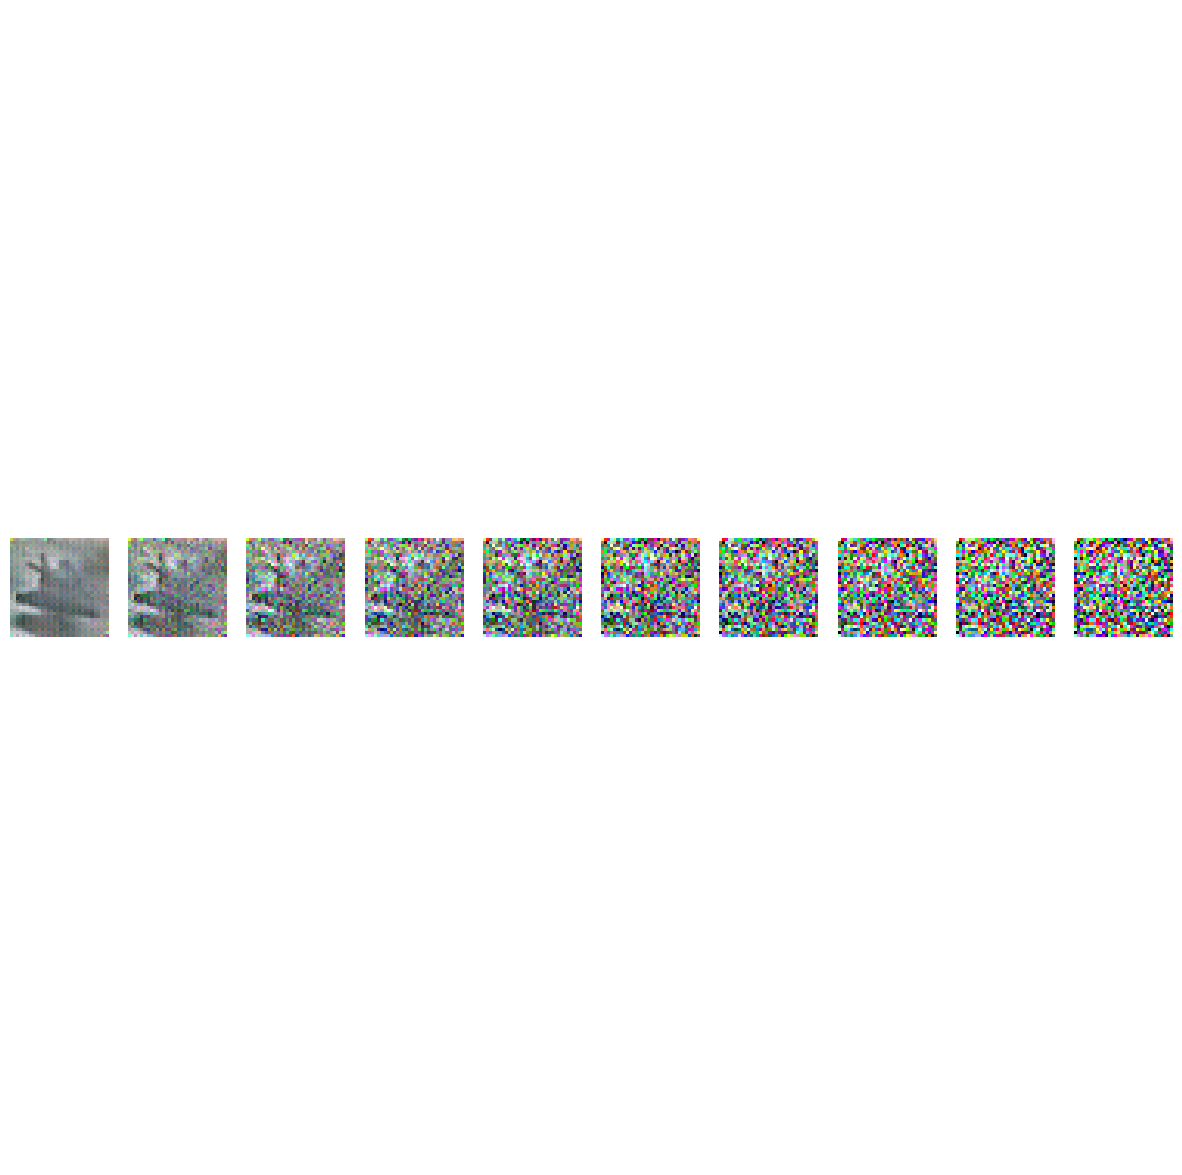

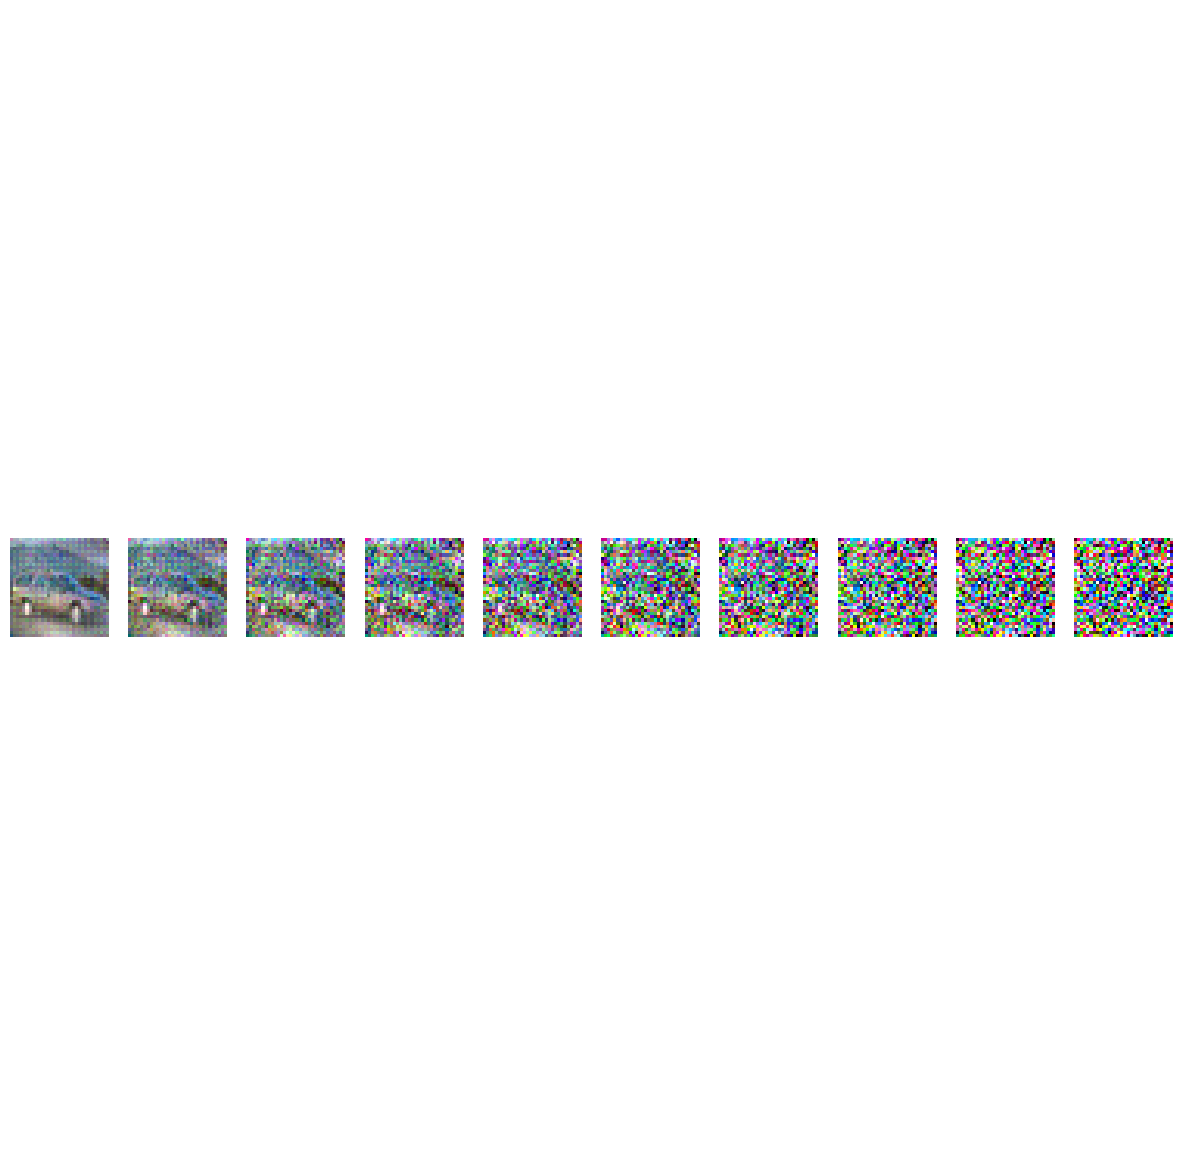

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▁▁▂▁▂▁▁
epoch,900
loss,0.05611


In [28]:
for epoch in tqdm(range(epochs)):
    model_cond.train()
    for i, (data, label) in enumerate(trainloader):
        optimizer.zero_grad()
        label = label.to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model_cond, data, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device, label)
        loss.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {1, 10, 50, 70, 90, 100, 200, 290, 300, 500, 800, 900, 990, 1000}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond, terms["posterior_variance"],num_classes)
                
        wandb.log({
        "epoch": epoch,
        "loss": loss.item(),
    })
                
wandb.finish()

TODO: FID Score:
 pysisch in path speichern

### visualize generated images and compare to original

In [79]:
with torch.no_grad():
    x_gen_cond_label0 = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond, terms["posterior_variance"],num_classes=num_classes, visualize=False, labels_default=[0])
    
    x_gen_cond_label1 = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model_cond, terms["posterior_variance"],num_classes=num_classes, visualize=False, labels_default=[1])

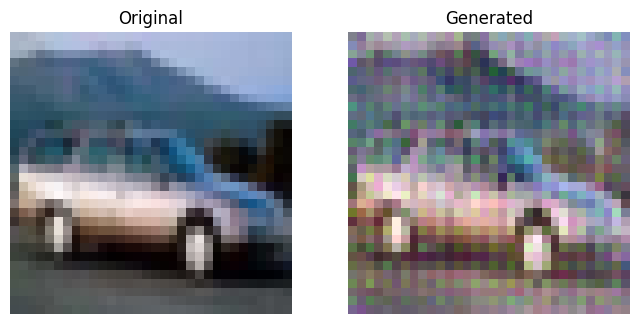

In [81]:
compare_images(trainset[0][0], x_gen_cond_label1[0][0].squeeze())

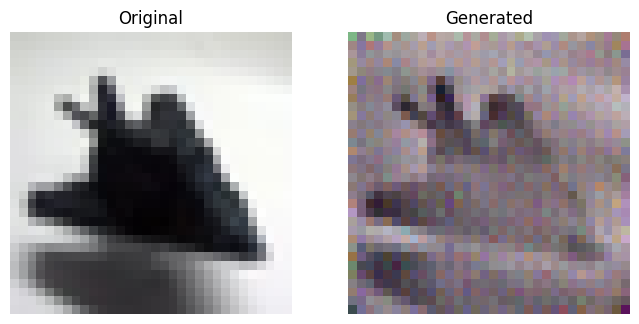

In [83]:
compare_images(trainset[1][0], x_gen_cond_label0[0][0].squeeze())

### FID Score

In [ ]:
# TODO: FID Score

### conclusion

In [ ]:
# TODO: Conclusion

## train on full data with all labels

### visualize generated images and compare to original

In [ ]:
# TODO: visualize generated images and compare to original

### FID Score

In [ ]:
# TODO: FID Score

### conclusion

In [ ]:
# TODO: Conclusion

# examples of generated images with different default labels

In [ ]:
# TODO: examples of generated images with different default labels

# summary